In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score, recall_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import accuracy_score, precision_score, classification_report

In [21]:
df = pd.read_csv("DigitalJail_Users_1M.csv", low_memory=False)
print("Dataset loaded →", df.shape)
df.head()


Dataset loaded → (1000000, 5)


,user_id,username,account_status,join_date,notes
0,U000001,user891144,Active,2025-06-29,Verified user
1,U000002,user359980,Suspended,2023-12-11,Verified user
2,U000003,user801593,Restricted,2025-06-28,No issues found
3,U000004,user659050,Suspended,2023-05-30,Deleted due to inactivity
4,U000005,user341550,Restricted,2025-03-01,Verified user


In [ ]:

target_col = "account_status"
print("Selected target column:", target_col)


Selected target column: account_status


In [23]:
drop_like = [c for c in df.columns if c.lower() in ["id", "user_id", "uid", "index"]]
df = df.drop(columns=drop_like, errors="ignore")

In [24]:
X = df.drop(columns=[target_col])
y = df[target_col]


In [25]:
X = X.dropna(axis=1, thresh=int(0.1 * len(X)))  
X = X.loc[:, X.nunique() > 1]


In [26]:
cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()


In [27]:
num_imputer = SimpleImputer(strategy="median")
cat_imputer = SimpleImputer(strategy="constant", fill_value="MISSING")
if num_cols:
    X[num_cols] = num_imputer.fit_transform(X[num_cols])
if cat_cols:
    X[cat_cols] = cat_imputer.fit_transform(X[cat_cols])


In [28]:
for c in cat_cols:
    top = X[c].value_counts().nlargest(100).index
    X[c] = X[c].where(X[c].isin(top), "__OTHER__")

In [29]:
ohe_cols = [c for c in cat_cols if X[c].nunique() <= 20]
le_cols = [c for c in cat_cols if c not in ohe_cols]

ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
X_ohe = pd.DataFrame()
if ohe_cols:
    X_ohe = pd.DataFrame(
        ohe.fit_transform(X[ohe_cols]),
        index=X.index,
        columns=ohe.get_feature_names_out(ohe_cols)
    )

In [30]:
for c in le_cols:
    le = LabelEncoder()
    X[c] = le.fit_transform(X[c].astype(str))


In [31]:
X_final = pd.concat(
    [X[num_cols].reset_index(drop=True),
     X[le_cols].reset_index(drop=True),
     X_ohe.reset_index(drop=True)], axis=1
)
print("Final feature matrix:", X_final.shape)

Final feature matrix: (1000000, 12)


In [32]:
le_y = LabelEncoder()
y_enc = le_y.fit_transform(y.astype(str))
classes = le_y.classes_
n_classes = len(classes)
print("Classes:", classes)

Classes: ['Active' 'Deleted' 'Restricted' 'Suspended']


In [33]:
max_rows = 200_000
if len(X_final) > max_rows:
    idx = np.random.choice(X_final.index, size=max_rows, replace=False)
    X_final = X_final.loc[idx]
    y_enc = y_enc[idx]
    print("Sampled to:", X_final.shape)

Sampled to: (200000, 12)


In [34]:
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y_enc, test_size=0.25, random_state=42, stratify=y_enc
)

In [35]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [36]:
model = GaussianNB()
unique_classes, counts = np.unique(y_train, return_counts=True)
total_samples = len(y_train)
class_frequencies = counts / total_samples


inverse_frequencies = 1 / class_frequencies
normalized_priors = inverse_frequencies / np.sum(inverse_frequencies)


model = GaussianNB(priors=normalized_priors)
model.fit(X_train, y_train)


GaussianNB(priors=array([0.0622843 , 0.3764501 , 0.18937265, 0.37189295]))

In [37]:
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)


C:\Users\darsh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\darsh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\darsh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classificati

Accuracy : 0.1007
Precision: 0.1831
Recall   : 0.2494
F1 Score : 0.0612

Classification Report:
              precision    recall  f1-score   support

      Active       0.54      0.00      0.00     30088
     Deleted       0.10      0.05      0.06      4978
  Restricted       0.00      0.00      0.00      9895
   Suspended       0.10      0.95      0.18      5039

    accuracy                           0.10     50000
   macro avg       0.18      0.25      0.06     50000
weighted avg       0.34      0.10      0.03     50000



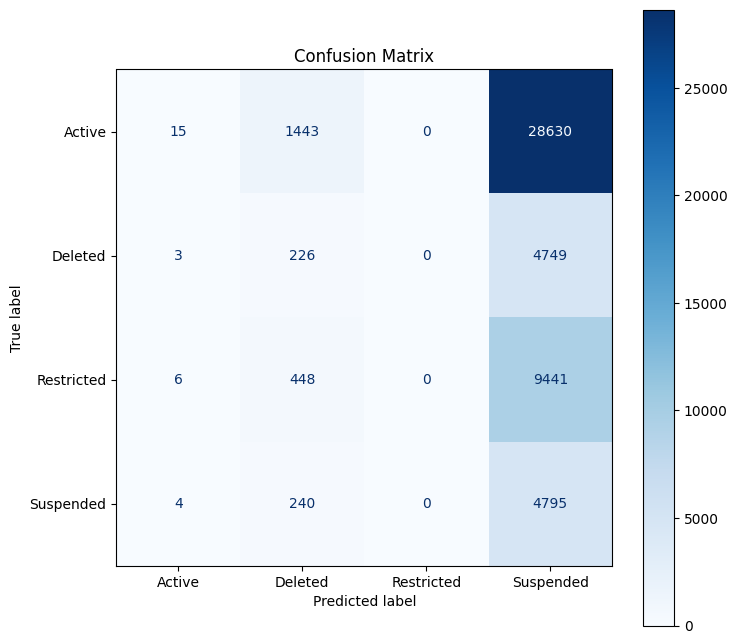

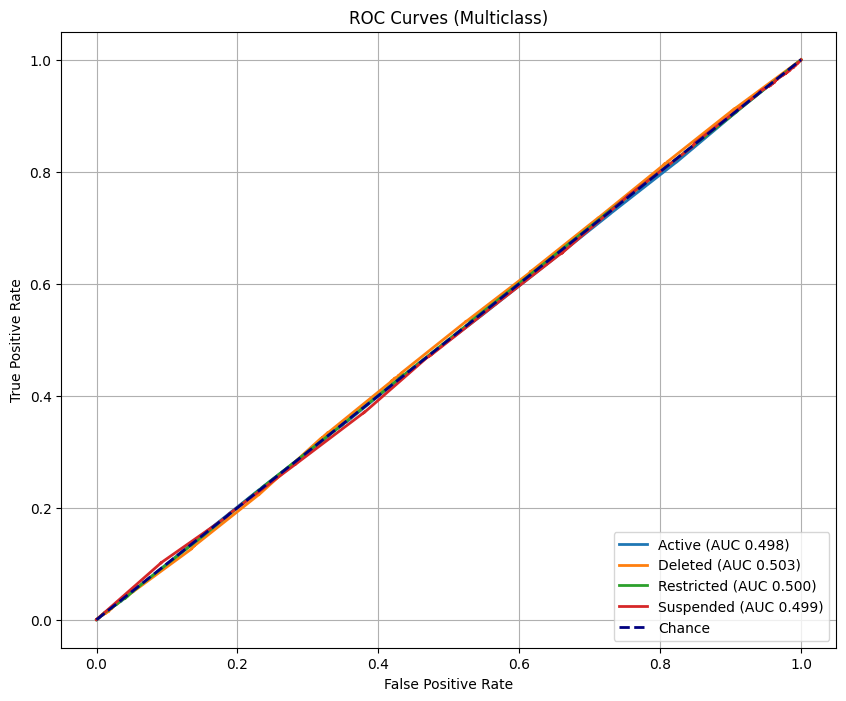

In [38]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average="macro")


from sklearn.metrics import f1_score, recall_score
if n_classes == 2:
    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
else:
    f1 = f1_score(y_test, y_pred, average="macro")
    recall = recall_score(y_test, y_pred, average="macro")

print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")


print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=classes))


cm = confusion_matrix(y_test, y_pred)


disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)


fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.title("Confusion Matrix")
plt.show()



if n_classes == 2:

    fpr, tpr, _ = roc_curve(y_test, y_prob[:, 1])
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
    plt.plot([0,1],[0,1],"--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()
else:
    y_test_bin = label_binarize(y_test, classes=np.unique(y_test))

    unique_classes = np.unique(y_test)
    n_unique_classes = len(unique_classes)

    fpr, tpr, roc_auc = {}, {}, {}

    plt.figure(figsize=(10, 8))

    for i in range(n_unique_classes):

        class_label = classes[i] if i < len(classes) else f"Class {unique_classes[i]}"

        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

        plt.plot(
            fpr[i], tpr[i],
            label=f"{class_label} (AUC {roc_auc[i]:.3f})",
            lw=2
        )

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle="--", label="Chance")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves (Multiclass)")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()